<a href="https://colab.research.google.com/github/ProjectRips/lightweight-model/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

training & result

In [5]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [50]:
# !pip install fastai
# !pip install fasterai
# !pip install fastkaggle
# !pip install timm
# !pip install optuna
# !pip install ipython-autotime
# %load_ext autotime
# !pip install memory_profiler


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 3.69 s (started: 2023-01-29 14:08:54 +00:00)


In [7]:
%cd /content/gdrive/MyDrive/Colab Notebooks/skripsi/lightweight

/content/gdrive/MyDrive/Colab Notebooks/skripsi/lightweight


In [53]:
from fastkaggle import *
import timm
from fastai.vision.all import *
import gc
import os
from matplotlib import pyplot as plt
import cv2
from fasterai.sparse.all import *
from memory_profiler import profile
import tracemalloc
set_seed(42)

time: 2.11 ms (started: 2023-01-29 14:17:35 +00:00)


In [13]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
User uploaded file "kaggle.json" with length 67 bytes


In [14]:
comp = 'data'

path = setup_comp(comp, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')

In [15]:
path

Path('data')

In [16]:
path.ls()

(#2) [Path('data/test'),Path('data/train')]

In [17]:
trn_path = path/'train'
files = get_image_files(trn_path)

print(trn_path)

data/train


In [18]:
models = {
    'convit_tiny': {
        (Resize(480, method='squish'), 224)
    },
}


In [23]:
def find_lr(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=15):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.25, item_tfms=item,
        batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=256//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=[error_rate], cbs=cbs).to_fp16()
    lr_valley, lr_slide = learn.lr_find(suggest_funcs=(valley, slide))
    
    return lr_valley, lr_slide


--- convit_tiny
224
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0}


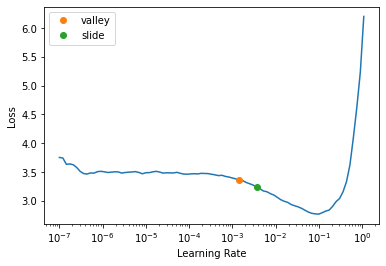

In [24]:
tta_res = []

for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        print(item.name)
        
        lr_valley, lr_slide = find_lr(arch, size, item=item, finetune=True, accum=4)
    
        gc.collect()
        torch.cuda.empty_cache()

In [ ]:
# def train(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=15):
#     dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.25, item_tfms=item,
#                                        batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=64//accum)

#     cbs = [GradientAccumulation(64) if accum else [], EarlyStoppingCallback(min_delta=1e-4, patience=10), SaveModelCallback(monitor="valid_loss")]
#     learn = vision_learner(dls, arch, metrics=[accuracy, error_rate], cbs=cbs).to_fp16()
#     learn.unfreeze()
#     learn.recorder.train_metrics = True
#     tst_files = get_image_files(path/'test').sorted()
#     if finetune:
#         learn.fine_tune(epochs, 0.01)
#         learn.recorder.plot_loss()
#         learn.recorder.plot_values()
#         learn.tta(dl=dls.test_dl(tst_files))
#     else:
#         learn.unfreeze()
#         learn.fit_one_cycle(epochs, 0.01)
#         learn.recorder.plot_loss()
#         learn.recorder.plot_values()

#     return learn, dls


In [32]:
import optuna
from optuna.integration import FastAIPruningCallback


BATCHSIZE = 256
EPOCHS = 1


def objective(trial):
    # Data Augmentation
    # tfms = aug_transforms(
    #         size=(Resize(480, method='squish'), 224), 
    #         min_scale=0.75,
            # do_flip=False,
            # flip_vert=False,
            # max_rotate=trial.suggest_int("max_rotate", 0, 45),
            # max_zoom=trial.suggest_float("max_zoom", 1, 2),
            # p_affine=trial.suggest_float("p_affine", 0.1, 1.0, step=0.1),
    # )
    data = ImageDataLoaders.from_folder(trn_path, valid_pct=0.25, item_tfms=(Resize(480, method='squish')),
                                       batch_tfms=aug_transforms(size=224, min_scale=0.75), bs=64//4)

    cbs = [ GradientAccumulation(64), 
           FastAIPruningCallback(trial)
                ]
    learn = vision_learner(
        data,
        'convit_tiny',
        metrics=[accuracy],
        # You could as FastAIPruningCallback in the fit function
        cbs=cbs
    )
    learn.unfreeze()


   

    # See https://forums.fast.ai/t/how-to-diable-progress-bar-completely/65249/3
    # to disable progress bar and logging info
    with learn.no_bar():
        with learn.no_logging():
            learn.fit(
            EPOCHS, 
            trial.suggest_float('lr', 1e-3, 1e-2), 
            cbs=[SparsifyCallback(sparsity=50, granularity='weight', context='local', criteria=large_final, schedule=agp)]
        )

    return learn.recorder.metrics[0].value.item()

In [33]:
# sampler = optuna.samplers.TPESampler()    
# study = optuna.create_study(
#     study_name="example-study",
#     sampler=sampler,
#     pruner=optuna.pruners.MedianPruner(
#         n_startup_trials=2, n_warmup_steps=5, interval_steps=3
#     ),
#     direction='maximize',
#     storage="sqlite:///convit.db")

# study.add_trials(study.trials)
study = optuna.load_study(study_name="example-study", storage="sqlite:///convit.db")
study.optimize(func=objective, n_trials=2)

Pruning of weight until a sparsity of [50]%
Saving Weights at epoch 0


[I 2023-01-29 13:34:33,577] Trial 6 finished with value: 0.2485576868057251 and parameters: {'lr': 0.005972574348572739}. Best is trial 2 with value: 0.8567307591438293.


Sparsity at the end of epoch 0: [50.0]%
Final Sparsity: [50.0]%
Sparsity in Conv2d 4: 50.00%
Pruning of weight until a sparsity of [50]%
Saving Weights at epoch 0


[I 2023-01-29 13:36:16,629] Trial 7 finished with value: 0.10528846085071564 and parameters: {'lr': 0.009243718551303341}. Best is trial 2 with value: 0.8567307591438293.


Sparsity at the end of epoch 0: [50.0]%
Final Sparsity: [50.0]%
Sparsity in Conv2d 4: 50.00%


In [41]:
torch.cuda.empty_cache()

time: 730 µs (started: 2023-01-29 13:54:57 +00:00)


In [47]:
tst_files = get_image_files(path/'test').sorted()

time: 6.87 s (started: 2023-01-29 14:05:27 +00:00)


--- vit_tiny_patch16_224
224
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0}
Pruning of weight until a sparsity of [50]%
Pruning of weight until a sparsity of [50]%
Saving Weights at epoch 0
Saving Weights at epoch 0


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.494053,2.028908,0.282212,0.717788,01:57


Sparsity at the end of epoch 0: [50.0]%
Sparsity at the end of epoch 0: [50.0]%
Final Sparsity: [50.0]%
Sparsity in Conv2d 4: 50.00%
Final Sparsity: [0.0]%
Sparsity in Conv2d 4: 50.00%
(4354184, 5460853)


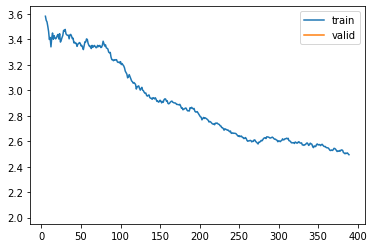

time: 1min 59s (started: 2023-01-29 14:28:45 +00:00)


In [54]:
models = {
    'vit_tiny_patch16_224': {
        (Resize(480, method='squish'), 224),
    }
}

tracemalloc.start()
for arch, details in models.items():
    for item, size in details:
        print('---', arch)
        print(size)
        print(item.name)

        dls = ImageDataLoaders.from_folder( trn_path, 
                                            valid_pct=0.25, 
                                            item_tfms=item,
                                            batch_tfms=aug_transforms(size=size, min_scale=0.75), 
                                            bs=64//4
                                            )

        cbs = [ GradientAccumulation(64), 
                EarlyStoppingCallback(min_delta=1e-4, patience=10), 
                # SaveModelCallback(monitor="accuracy"),
                SparsifyCallback(sparsity=50, granularity='weight', context='local', criteria=large_final, schedule=agp), 
                FastAIPruningCallback(study.best_trial, monitor="accuracy")
                ]
        learn = vision_learner(dls, arch, metrics=[
            accuracy, error_rate], cbs=cbs).to_fp16()
        
        learn.unfreeze()
        learn.fit_one_cycle(
            1, 
            0.01, 
            cbs=[SparsifyCallback(sparsity=50, granularity='weight', context='local', criteria=large_final, schedule=agp), 
            FastAIPruningCallback(study.best_trial, monitor="accuracy")]
        )
        learn.recorder.plot_loss()

        gc.collect()
        torch.cuda.empty_cache()
print(tracemalloc.get_traced_memory())

tracemalloc.stop()


In [43]:
total_params(learn.model)

(5629248, True)

time: 8.42 ms (started: 2023-01-29 13:57:23 +00:00)


In [44]:
models = {
    'vit_tiny_patch16_224': {
        (Resize(480, method='squish'), 224),
    }
}


for arch, details in models.items():
    for item, size in details:
        print('---', arch)
        print(size)
        print(item.name)

        dls = ImageDataLoaders.from_folder( trn_path, 
                                            valid_pct=0.25, 
                                            item_tfms=item,
                                            batch_tfms=aug_transforms(size=size, min_scale=0.75), 
                                            bs=64//4
                                            )

        cbs = [ GradientAccumulation(64), 
                EarlyStoppingCallback(min_delta=1e-4, patience=10), 
                # SaveModelCallback(monitor="accuracy"),
                ]
        learn = vision_learner(dls, arch, metrics=[
            accuracy, error_rate], cbs=cbs).to_fp16()
        learn.unfreeze()
        learn.fit_one_cycle(
            1, 
            0.01, 
            cbs=[SparsifyCallback(sparsity=50, granularity='weight', context='local', criteria=large_final, schedule=agp)] 
        )

        gc.collect()
        torch.cuda.empty_cache()


--- vit_tiny_patch16_224
224
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0}
Pruning of weight until a sparsity of [50]%
Saving Weights at epoch 0


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.391743,1.937220,0.303365,0.696635,01:46


Sparsity at the end of epoch 0: [50.0]%
Final Sparsity: [50.0]%
Sparsity in Conv2d 4: 50.00%
time: 1min 47s (started: 2023-01-29 13:57:23 +00:00)


In [45]:
total_params(learn.model)

(5629248, True)

time: 7.63 ms (started: 2023-01-29 13:59:11 +00:00)


In [ ]:
pruner = Pruner()
pruned_model = pruner.prune_model(learn.model)

In [ ]:
from fastai.text.all import * 
learner= learn.load("vit_tiny_patch16_224")

In [ ]:
interpret = ClassificationInterpretation.from_learner(learner)

In [ ]:
interpret.print_classification_report()

In [ ]:
interpret.plot_confusion_matrix(title="vit_tiny_patch16_224")

In [ ]:
for arch,details in models.items():
    for item,size in details:        
        dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.25, item_tfms=item,
                batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=32//4)
        tst_files = get_image_files(path/'test').sorted()
        tst_dl = dls.test_dl(tst_files, with_labels=True, num_workers=0)
        tst_dl

In [ ]:
acc = accuracy(*learner.get_preds(dl=tst_dl))
print('The accuracy is {0} %.'.format(acc))